In [ ]:
fimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# Montamos la unidad de drive y trabajamos con los datasets y modelos preparados
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

In [ ]:
#!kaggle datasets download -d tommyngx/cmmd2022
!kaggle datasets download -d taruto1215/cmmd-breast-cancer-dicom-resized-2048-png
#!unzip /content/cbis-ddsm-breast-cancer-image-dataset.zip -d /content/cbis-ddsm
#!mv /content/cbis-ddsm /content/drive/MyDrive/

Dataset URL: https://www.kaggle.com/datasets/taruto1215/cmmd-breast-cancer-dicom-resized-2048-png
License(s): unknown
100% 3.17G/3.18G [00:41<00:00, 71.2MB/s]
100% 3.18G/3.18G [00:41<00:00, 81.7MB/s]


In [ ]:
!unzip -q /content/cmmd-breast-cancer-dicom-resized-2048-png.zip -d /content/drive/MyDrive/

In [ ]:
!mv /content/output /content/drive/MyDrive/

In [ ]:
!mv '/content/TheChineseMammographyDatabase/CMMD' '/content/'
!mv '/content/TheChineseMammographyDatabase/CMMD_clinicaldata_revision.xlsx' '/content/CMMD'
!mv '/content/TheChineseMammographyDatabase/metadata.csv' '/content/CMMD'
!rm -Rf '/content/TheChineseMammographyDatabase'

In [ ]:
ruta_clinicalData = '/content/drive/MyDrive/output/CMMD_clinicaldata_revision.xlsx'
clinicaldataDF = pd.read_excel(ruta_clinicalData)
clinicaldataDF.head()

In [ ]:
ruta_metadata = '/content/drive/MyDrive/output/metadata.csv'
metadataDF = pd.read_csv(ruta_metadata)
metadataDF.head()

In [ ]:
!pip install pydicom

In [ ]:
clinicaldataDF['abnormality'].unique()

array(['calcification', 'both', 'mass'], dtype=object)

<ipython-input-12-4683c8a4d73f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=abnormality_counts.index, y=abnormality_counts.values, palette='viridis')


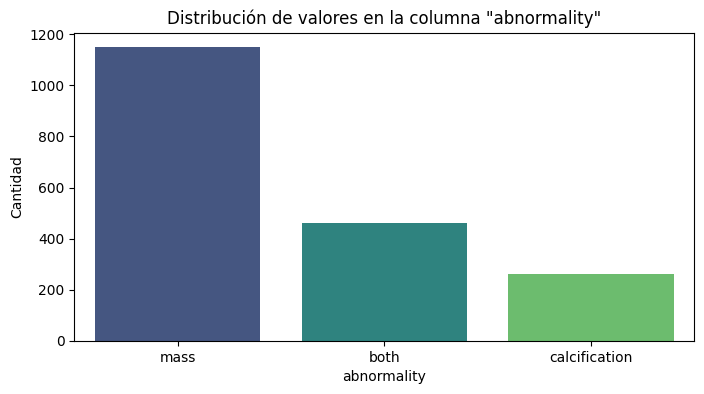

In [ ]:
abnormality_counts = clinicaldataDF['abnormality'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=abnormality_counts.index, y=abnormality_counts.values, palette='viridis')

plt.ylabel('Cantidad')
plt.title('Distribución de valores en la columna "abnormality"')

plt.show()

In [ ]:
clinicaldataDF['classification'].unique()

array(['Benign', 'Malignant'], dtype=object)

<ipython-input-14-d682de618145>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classification_counts.index, y=classification_counts.values, palette='viridis')


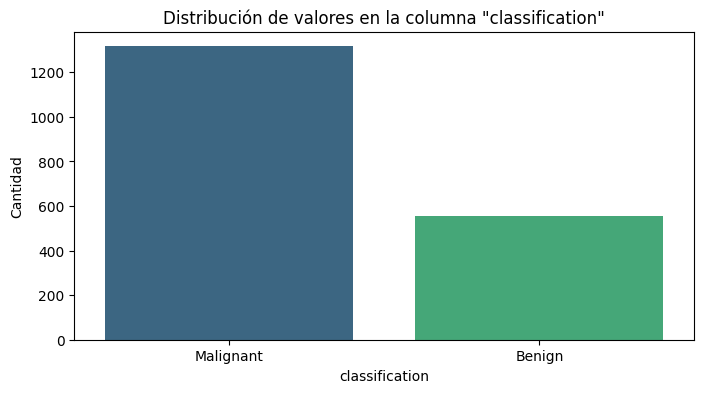

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

classification_counts = clinicaldataDF['classification'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=classification_counts.index, y=classification_counts.values, palette='viridis')

plt.ylabel('Cantidad')
plt.title('Distribución de valores en la columna "classification"')

plt.show()

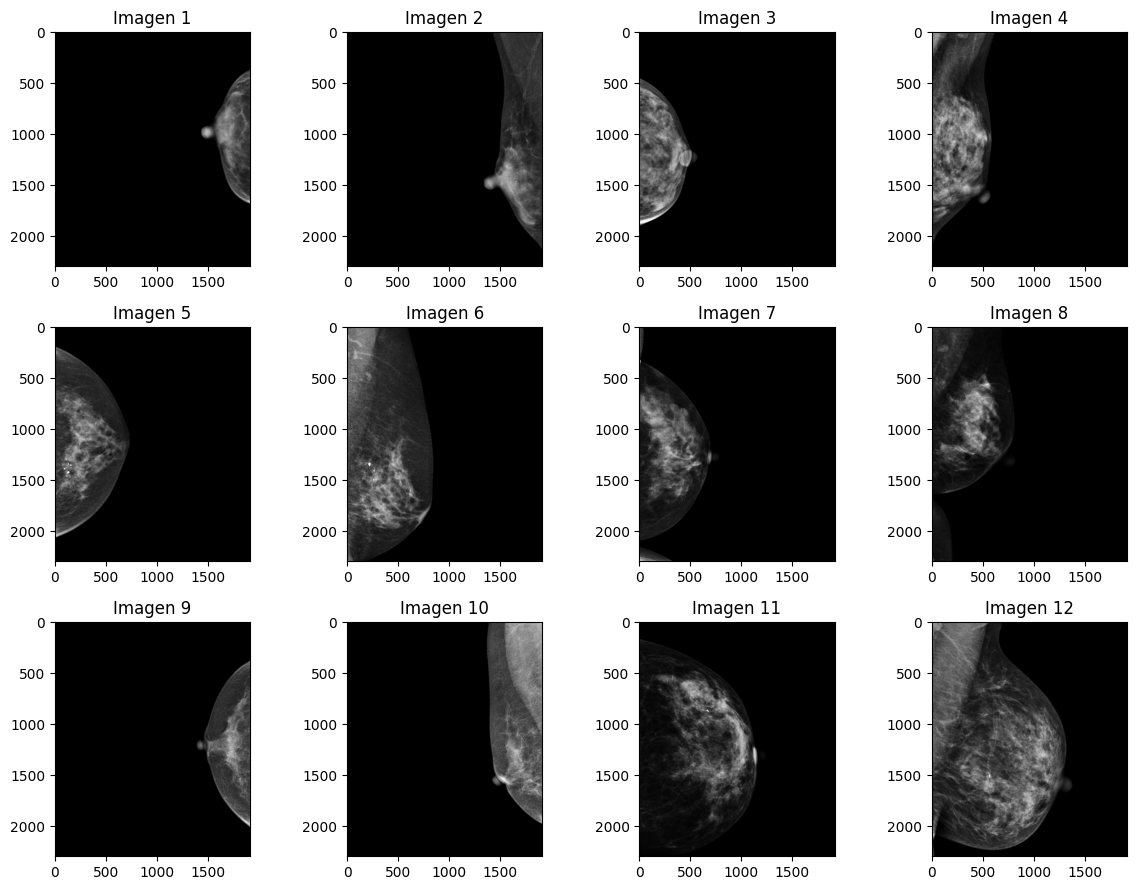

In [ ]:
def mostrar_imagenes_malla(rutas_imagenes, filas, columnas):
    fig = plt.figure(figsize=(columnas*3, filas*3))

    gs = gridspec.GridSpec(filas, columnas)

    for i, ruta_imagen in enumerate(rutas_imagenes):
        ax = fig.add_subplot(gs[i])
        imagen = mpimg.imread(ruta_imagen)
        ax.imshow(imagen, cmap='gray')
        ax.axis('on')
        ax.set_title(f'Imagen {i+1}')

    plt.tight_layout()
    plt.show()

imagenesGrid = []

for index, row in metadataDF.iterrows():
    dir_path = row["File Location"]
    jpg_files = [f for f in os.listdir(dir_path) if f.lower().endswith('.jpg')]

    for jpg_file in jpg_files:
        img_path = os.path.join(dir_path, jpg_file)
        imagenesGrid.append(img_path)

filas = 3
columnas = 4
mostrar_imagenes_malla(imagenesGrid[:12], filas, columnas)

In [ ]:
# CARGA INICIAL DE IMÁGENES A TENSOR PYTORCH

images_directory = "/content/drive/MyDrive/output/images"
X = []
y = []
contador = 1
filas = 224
columnas = 224

transform = transforms.Compose([
    transforms.Resize((filas, columnas)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

for filename in os.listdir(images_directory):
    if filename.endswith(".png"):
        image_id = filename.split("_")[0]
        classification = clinicaldataDF.loc[clinicaldataDF["ID1"] == image_id, "classification"].values[0]
        img = Image.open(os.path.join(images_directory, filename))
        img_tensor = transform(img)

        X.append(img_tensor)
        y.append(0 if classification == "Benign" else 1)

        if(contador % 100 == 0):
          print(f'Cargada imagen {contador}')

        contador = contador + 1

X_tensor = torch.stack(X)
y_tensor = torch.tensor(y)

In [ ]:
X_tensor.shape

torch.Size([5202, 1, 224, 224])

In [ ]:
y_tensor.shape

torch.Size([5202])

In [ ]:
torch.save(X_tensor, "/content/drive/MyDrive/output/X.pt")
torch.save(y_tensor, "/content/drive/MyDrive/output/y.pt")

In [ ]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=42)

In [ ]:
print("Conjunto de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", y_train.shape)
print("Conjunto de prueba:", X_test.shape)
print("Etiquetas de prueba:", y_test.shape)

Conjunto de entrenamiento: torch.Size([4161, 1, 224, 224])
Etiquetas de entrenamiento: torch.Size([4161])
Conjunto de prueba: torch.Size([1041, 1, 224, 224])
Etiquetas de prueba: torch.Size([1041])


In [ ]:
# Grabar tensores originales, sin oversampling ni ningún otro tratamiento
torch.save(X_train, "/content/drive/MyDrive/output/X_train.pt")
torch.save(y_train, "/content/drive/MyDrive/output/y_train.pt")
torch.save(X_test, "/content/drive/MyDrive/output/X_test.pt")
torch.save(y_test, "/content/drive/MyDrive/output/y_test.pt")

In [ ]:
X_train = torch.load("/content/drive/MyDrive/output/X_train.pt")
y_train = torch.load("/content/drive/MyDrive/output/y_train.pt")
X_test = torch.load("/content/drive/MyDrive/output/X_test.pt")
y_test = torch.load("/content/drive/MyDrive/output/y_test.pt")

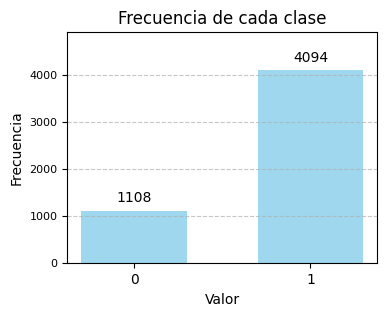

In [ ]:
valores_unicos, indices = torch.unique(y_tensor, return_inverse=True)
frecuencias = torch.bincount(indices)

valores = valores_unicos.tolist()
frecuencias = frecuencias.tolist()

plt.figure(figsize=(4, 3))
bars = plt.bar(valores, frecuencias, width=0.6, color='skyblue', alpha=0.8)

plt.ylim(0, max(frecuencias) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(frecuencias) * 0.03, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Frecuencia de cada clase', fontsize=12)
plt.xlabel('Valor', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(valores, fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.utils import resample

images_directory = "/content/drive/MyDrive/output/images"
X = []
y = []
contador = 1

# Definimos la transformación para preprocesar las imágenes
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

X_sobremuestreado = []
y_sobremuestreado = []

for filename in os.listdir(images_directory):
    if filename.endswith(".png"):
        image_id = filename.split("_")[0]
        classification = clinicaldataDF.loc[clinicaldataDF["ID1"] == image_id, "classification"].values[0]
        img = Image.open(os.path.join(images_directory, filename))
        img_tensor = preprocess(img)

        X.append(img_tensor)
        y.append(0 if classification == "Benign" else 1)

        if(contador % 100 == 0):
            print(f'Cargada imagen {contador}')

        contador += 1

X_numpy = torch.stack(X).numpy()
y_numpy = np.array(y)

# Separamos por clase
X_clase_0 = X_numpy[y_numpy == 0]
X_clase_1 = X_numpy[y_numpy == 1]

# Realizar sobremuestreo de la clase minoritaria (clase 0 en este caso)
X_clase_0_oversampled = resample(X_clase_0, replace=True, n_samples=len(X_clase_1), random_state=42)

X_sobremuestreado = np.concatenate([X_clase_0_oversampled, X_clase_1])
y_sobremuestreado = np.concatenate([np.zeros(len(X_clase_1)), np.ones(len(X_clase_1))])

X_oversampled = torch.tensor(X_sobremuestreado)
y_oversampled = torch.tensor(y_sobremuestreado)
y_oversampled = y_oversampled.long().clamp(0, 1)

In [ ]:
X_oversampled.shape

torch.Size([8188, 1, 224, 224])

In [ ]:
y_oversampled.shape

torch.Size([8188])

In [ ]:
torch.save(X_oversampled, "/content/drive/MyDrive/output/X_oversampled.pt")
torch.save(y_oversampled, "/content/drive/MyDrive/output/y_oversampled.pt")

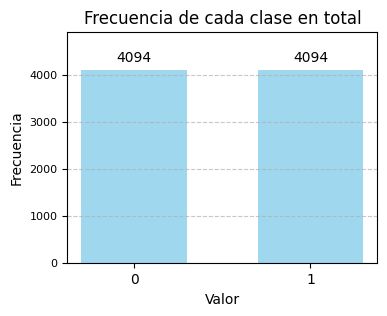

In [ ]:
valores_unicos, indices = torch.unique(y_oversampled, return_inverse=True)
frecuencias = torch.bincount(indices)

valores = valores_unicos.tolist()
frecuencias = frecuencias.tolist()

plt.figure(figsize=(4, 3))
bars = plt.bar(valores, frecuencias, width=0.6, color='skyblue', alpha=0.8)

plt.ylim(0, max(frecuencias) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + max(frecuencias) * 0.03, int(yval), ha='center', va='bottom', fontsize=10)

plt.title('Frecuencia de cada clase en total', fontsize=12)
plt.xlabel('Valor', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(valores, fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
from skimage import exposure

def local_contrast_normalization(tensor, kernel_size=7):
    image = tensor.numpy()
    images = []

    for i in range(image.shape[0]):
        img = image[i]

        local_mean = F.avg_pool2d(torch.tensor(img).unsqueeze(0).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze().numpy()
        local_sqr_mean = F.avg_pool2d(torch.tensor(img**2).unsqueeze(0).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze().numpy()
        local_var = local_sqr_mean - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 1e-10))  # Evitar división por cero
        lcn_image = (img - local_mean) / (local_std + 1e-10)

        images.append(lcn_image)

    tensor = torch.tensor(np.stack(images))
    return tensor

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)

    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev**2 + 10e-6)

    return gcn_image_tensor

def LCN_GCN_preprocess(tensor):
    gcn_tensor = global_contrast_normalization(tensor)
    lcn_tensor = local_contrast_normalization(gcn_tensor)

    return lcn_tensor

X_train_LCN_GCN = LCN_GCN_preprocess(X_train)

train_dataset = TensorDataset(X_train_LCN_GCN, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

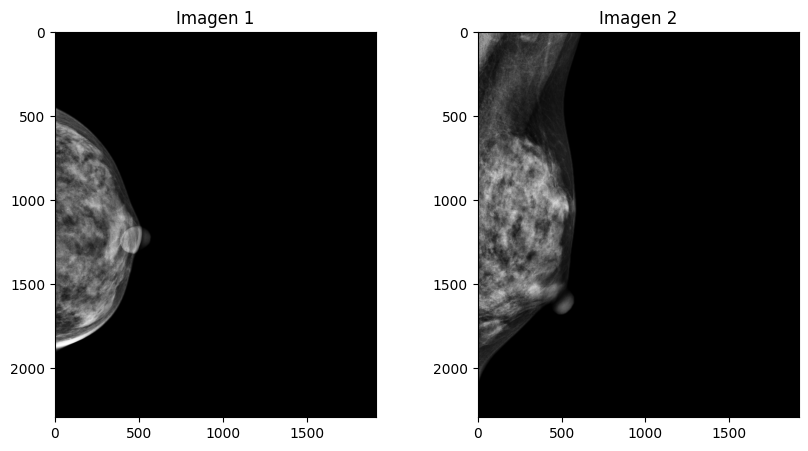

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

jpg1_path = '/content/cmmd/CMMD/CMMD/D1-0002/07-18-2010-NA-NA-49231/1.000000-NA-45313/1-1.jpg'
jpg2_path = '/content/cmmd/CMMD/CMMD/D1-0002/07-18-2010-NA-NA-49231/1.000000-NA-45313/1-2.jpg'

img1 = mpimg.imread(jpg1_path)
img2 = mpimg.imread(jpg2_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1,cmap='gray')
plt.title('Imagen 1')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(img2,cmap='gray')
plt.title('Imagen 2')
plt.axis('on')

plt.show()